## Load OpenMeteo Daily Data

In [1]:
import requests
import pandas as pd

locations = {
    'Metzingen' : {'lat':52.67057, 'long':10.37136},
    'Hannover Station 2014':  {'lat':52.4644, 'long':9.6779}
    }

dates = {
      'StartDate': '2022-01-01',
      'EndDate': '2024-11-11'
    }

loc = 'Metzingen'

daily = [
  'sunshine_duration',
  'rain_sum',
  'wind_speed_10m_max',
  'wind_gusts_10m_max',
  'wind_direction_10m_dominant',
  'temperature_2m_mean',
  'precipitation_hours'
]

openmeteo = f'https://archive-api.open-meteo.com/v1/archive?latitude={locations[loc]["lat"]}&longitude={locations[loc]["long"]}&start_date={dates["StartDate"]}&end_date={dates["EndDate"]}&daily={",".join(daily)}&timezone=GMT'

res = requests.get(openmeteo)
if res.status_code == 200:
  data = res.json()



for k in data['daily_units']:
  print(k,data['daily_units'][k])


df = pd.DataFrame(data['daily'], columns= data['daily_units'])

df.head()


time iso8601
sunshine_duration s
rain_sum mm
wind_speed_10m_max km/h
wind_gusts_10m_max km/h
wind_direction_10m_dominant °
temperature_2m_mean °C
precipitation_hours h


,time,sunshine_duration,rain_sum,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,temperature_2m_mean,precipitation_hours
0,2022-01-01,0.00,0.5,22.1,42.5,241,11.3,5.0
1,2022-01-02,5070.98,2.5,28.7,56.2,232,10.4,10.0
2,2022-01-03,15384.78,7.4,33.0,69.8,249,8.0,12.0
3,2022-01-04,0.00,4.0,17.6,35.6,245,5.7,11.0
4,2022-01-05,3574.57,1.2,30.2,65.2,254,2.6,8.0


## DWD - OpenMeteo comparison moved

* new [notebook](./compare_DWD_OpenMeteo.ipynb)

## Get DHV XC flight data

* Metzingen
* Lüdingen
* Leese, Estorf (GC Landesbergen)

In [2]:
import requests
import urllib
import pandas as pd

PAGE_SIZE = 500

places = {
    'Metzingen':11185,
    'Rammelsberg': 9427,
    'Estorf': 11001,
    'Leese': 10746,
    'Porta': 9712,
    'Lüdingen':9759,
    'Brunsberg': 9844,
    'Kella': 9521,
    'Börry': 9403
}

results = []
for place in ['Metzingen','Estorf','Leese','Lüdingen']:
# for place in ['Metzingen']:
    limit = PAGE_SIZE
    for start in [0,PAGE_SIZE]:
        query = {"navpars":{"start":start,"limit":limit,"sort":[{"field":"FlightDate","dir":-1},{"field":"BestTaskPoints","dir":-1}]}}
        # for some reason, " is replaced by ' and spaces are added which is replaced by +
        decoded_url = f"https://de.dhv-xc.de/api/fli/flights?s?fkcat%5B%5D=1&fkto%5B%5D={places[place]}&{urllib.parse.urlencode(query,quote_via=urllib.parse.quote_plus).replace('%27', '%22').replace('+', '')}"
        #print(decoded_url)
        r = requests.get(decoded_url)
        if r.status_code==200:
            response = r.json()
            df0 = pd.DataFrame(response['data'])
            #print(df.columns.values)
            results.extend(df0[['FlightDate', 'TakeoffWaypointName' , 'Glider' ,'FlightDuration','UtcOffset', 'FlightStartTime']].values)


df_results = pd.DataFrame(results,columns=['FlightDate','Takeoff', 'Glider' ,'Duration','UtcOffset', 'FlightStartTime'])
print(len(df_results))
df_results.tail()

4000


,FlightDate,Takeoff,Glider,Duration,UtcOffset,FlightStartTime
3995,2021-04-20,Lüdingen,Arriba 3 S,513,2,2021-04-20 16:43:38
3996,2021-04-20,Lüdingen,MiuraRS - ML [LTF A],516,2,2021-04-20 20:02:08
3997,2021-04-20,Lüdingen,BuzzZ5,576,2,2021-04-20 13:36:34
3998,2021-04-20,Lüdingen,MiuraRS - ML [LTF A],477,2,2021-04-20 15:39:31
3999,2021-04-20,Lüdingen,Alpha 6,533,2,2021-04-20 15:50:03


## Merge weather and flight data for training and testing

* Weather data : OpenMeteo daily @ Hannover
* Flight data: Sundays and Saturdays, all 4 locations

* Training data < 2024
* Test data >= 2024

In [3]:
import numpy as np
from datetime import datetime
print(loc, locations[loc])
df['Weekday'] = df.apply(lambda row:datetime.strftime(datetime.strptime(row['time'],'%Y-%m-%d'),'%a'), axis=1)
#df['alignment'] =  df.apply(lambda row: np.cos(row['wind_direction_10m_dominant']*np.pi/180.)**2,axis=1)
df = df[df['Weekday'].isin(['Sat','Sun'])]
#print(df.head())

dhv_aggr = df_results[df_results['FlightDate'] >= '2022-01-01'].groupby('FlightDate')['Duration'].count().reset_index()
#dhv_aggr['Weekday'] = dhv_aggr.apply(lambda row:  datetime.strftime(datetime.strptime(row['FlightDate'],'%Y-%m-%d'),'%a'), axis=1)
dhv_aggr.rename(columns={'FlightDate':'time'},inplace=True)
#dhv_aggr.head()

dfm = df.merge(dhv_aggr, on='time', how='left')
dfm.rename(columns={
    'sunshine_duration':'sun',
    'rain_sum':'rain',
    'wind_speed_10m_max':'wind',
    'wind_gusts_10m_max':'gust',
    'wind_direction_10m_dominant':'dir',
    'temperature_2m_mean': 'temp',
    'precipitation_hours': 'rain_dur',
    'Duration':'flights'
    },inplace=True)
dfm = dfm.drop(['Weekday'] ,axis=1).fillna(0)

Metzingen {'lat': 52.67057, 'long': 10.37136}


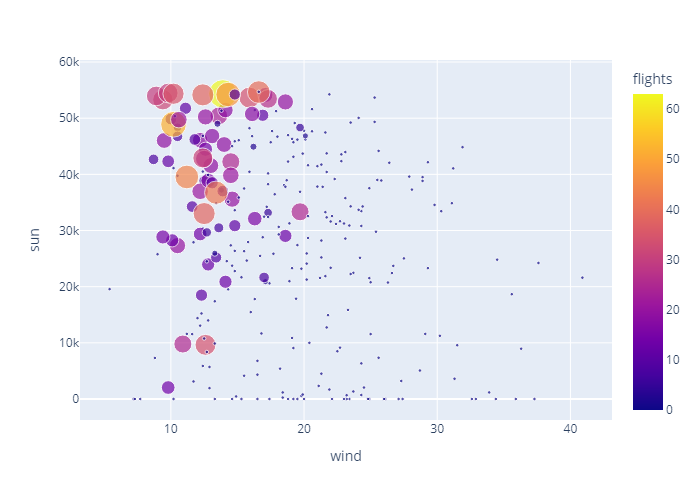

In [4]:
import plotly.express as px 
dfm['size']= dfm.apply(lambda row: row['flights']+1, axis=1)
fig = px.scatter(dfm, x='wind', y='sun', hover_data=['gust','rain','dir','sun','time'], size='size', color='flights')

dfm.drop(columns=['size'],inplace=True)
fig.show('png')


## Train model

* RandomForestRegressor with n estimators (decision trees)
* Optimize parameters including threshold (bias)

In [20]:

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor,  plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import numpy as np

features = ['wind','gust','rain','sun']
scales = np.asarray([1.0/x for x in [20.,20.,5.0, 50000.]])

test_filter =(dfm['time'] >= '2024-01-01')
train_filter = (dfm['time'] < '2024-01-01') & (dfm['time'] >= '2023-01-01')
xtrain = dfm[train_filter][features].to_numpy()
ytrain = dfm[train_filter]['flights'].to_numpy()


print(np.shape(xtrain),np.shape(ytrain))

regr = RandomForestRegressor(random_state=0,n_estimators=50,max_depth=4,max_features=0.98,criterion='squared_error')
regr.fit(xtrain,ytrain)

regr2 = KNeighborsRegressor(n_neighbors=11)
regr2.fit(xtrain*scales,ytrain)


regr3 = ExtraTreesRegressor(random_state=0,n_estimators=200)
#regr3=SVR(C=0.5, epsilon=0.075)
#regr3 =MLPRegressor(hidden_layer_sizes=(10))
regr3.fit(xtrain*scales,ytrain)



ypred = regr.predict(xtrain)
ypred2 = regr2.predict(xtrain*scales)
ypred3 = regr3.predict(xtrain*scales)

def eval_training(ytrain, yp, thresholds):
    for thr in thresholds:
        tp = len([1 for j in range(len(ytrain)) if ytrain[j] > 0 and yp[j] >= thr])
        fp = len([1 for j in range(len(ytrain)) if ytrain[j] == 0 and yp[j] >= thr])
        fn = len([1 for j in range(len(ytrain)) if ytrain[j] > 0 and yp[j] < thr])
        prec, rec = tp/(tp+fp) , tp/(tp+fn)
        f1score = 2.0*prec*rec/(prec+rec)
        print(f'{thr:.4f} ,{prec:.4f}, {rec:.4f}, {f1score:.4f}')

print('random forest')
eval_training(ytrain, ypred, [2,2.5,3,3.5,4.])

print('knn')
eval_training(ytrain, ypred2, [6.,6.5,7,7.5,8.])

print(regr3)
eval_training(ytrain, ypred3, [0.,1.,2.,3.,4.,5.])



#
dfm['predict'] = dfm[test_filter | train_filter].apply(lambda row: regr.predict([row[features].to_numpy()])[0], axis=1)
dfm['predict2'] = dfm[test_filter | train_filter].apply(lambda row: regr2.predict([row[features].to_numpy()]*scales)[0], axis=1)
dfm['predict3'] = dfm[test_filter | train_filter].apply(lambda row: regr3.predict([row[features].to_numpy()]*scales)[0], axis=1)

(105, 4) (105,)
random forest
2.0000 ,0.6389, 1.0000, 0.7797
2.5000 ,0.6875, 0.9565, 0.8000
3.0000 ,0.7097, 0.9565, 0.8148
3.5000 ,0.7241, 0.9130, 0.8077
4.0000 ,0.7241, 0.9130, 0.8077
knn
6.0000 ,0.6667, 0.8696, 0.7547
6.5000 ,0.7407, 0.8696, 0.8000
7.0000 ,0.7407, 0.8696, 0.8000
7.5000 ,0.7826, 0.7826, 0.7826
8.0000 ,0.7826, 0.7826, 0.7826
ExtraTreesRegressor(n_estimators=200, random_state=0)
0.0000 ,0.2190, 1.0000, 0.3594
1.0000 ,1.0000, 1.0000, 1.0000
2.0000 ,1.0000, 1.0000, 1.0000
3.0000 ,1.0000, 0.9565, 0.9778
4.0000 ,1.0000, 0.9130, 0.9545
5.0000 ,1.0000, 0.9130, 0.9545


## Evaluate

* Choose some threshold to define categories
* Calculate  measures

In [21]:
thr = 3. # from the maximum f1-score above

found = (dfm['predict']/3.0 + dfm['predict2']/7.0 >= 2.0) 
found = (dfm['predict'] >= thr) 
found = (dfm['predict3'] >= 3.5) 

tp = dfm[test_filter & (dfm['flights'] > 0) & found]
tn = len(dfm[test_filter & ~(dfm['flights'] > 0) & ~found])
fp = dfm[test_filter & ~(dfm['flights'] > 0) & found]
fn = dfm[test_filter & (dfm['flights'] > 0) & ~found]

print('true pos', len(tp))
print('true neg', tn)
print('false pos', len(fp))
print('false neg', len(fn))

print('precision:', len(tp)/(len(tp)+len(fp)), 'recall:', len(tp)/(len(tp)+len(fn)) )
#print("true positives","\n", tp.to_markdown())
print("\nfalse negatives\n\n", fn.to_markdown())
print("\nfalse positives\n\n",fp.to_markdown())

true pos 22
true neg 61
false pos 5
false neg 2
precision: 0.8148148148148148 recall: 0.9166666666666666

false negatives

 |     | time       |     sun |   rain |   wind |   gust |   dir |   temp |   rain_dur |   flights |   predict |   predict2 |   predict3 |
|----:|:-----------|--------:|-------:|-------:|-------:|------:|-------:|-----------:|----------:|----------:|-----------:|-----------:|
| 241 | 2024-04-21 | 46848.1 |    0.2 |   20.1 |   42.8 |    52 |    4.5 |          2 |         2 |   1.14513 |    7.27273 |      0.015 |
| 263 | 2024-07-07 | 48333.4 |    0.1 |   19.7 |   41.8 |   234 |   16.6 |          1 |         5 |   9.50181 |    7.27273 |      1.25  |

false positives

 |     | time       |     sun |   rain |   wind |   gust |   dir |   temp |   rain_dur |   flights |   predict |   predict2 |   predict3 |
|----:|:-----------|--------:|-------:|-------:|-------:|------:|-------:|-----------:|----------:|----------:|-----------:|-----------:|
| 234 | 2024-03-30 | 39900.9 

In [22]:
# 2022 ?!

df_2022 = dfm[(dfm['time'] < '2023-01-01') & (dfm['time'] >= '2022-06-01')].copy(deep=True)

df_2022['predict'] = df_2022.apply(lambda row: regr.predict([row[features].to_numpy()])[0], axis=1)

df_2023= df_results[(df_results['Takeoff'].isin(['Metzingen','Rammelsberg'])) & (df_results['FlightDate']<='2023-01-01') & (df_results['FlightDate'] >= '2022-01-01')].copy(deep=True)
m_2022 = pd.pivot_table(df_2023,index='FlightDate',columns='Takeoff',values='Duration', aggfunc='count').reset_index()
m_2022.rename(columns={'FlightDate':'time'},inplace=True)

print(df_2022[(df_2022['predict'] > 9.0 ) | (df_2022['flights'] > 0 )].merge(m_2022, on='time',how='left').fillna(0).to_markdown())


|    | time       |     sun |   rain |   wind |   gust |   dir |   temp |   rain_dur |   flights |   predict |   predict2 |   predict3 |   Metzingen |
|---:|:-----------|--------:|-------:|-------:|-------:|------:|-------:|-----------:|----------:|----------:|-----------:|-----------:|------------:|
|  0 | 2022-06-04 | 53667.5 |    0   |   15.9 |   31.3 |    34 |   17.5 |          0 |        34 |  18.9303  |          0 |          0 |          22 |
|  1 | 2022-06-25 | 48377.2 |    0.2 |   10.5 |   24.8 |   261 |   23.3 |          2 |         5 |  13.8289  |          0 |          0 |           0 |
|  2 | 2022-07-02 | 54341.3 |    0   |   13.9 |   31   |   204 |   19.7 |          0 |        63 |  33.9969  |          0 |          0 |          23 |
|  3 | 2022-07-03 | 54139.2 |    0.1 |   17.1 |   33.8 |   244 |   22.4 |          1 |        17 |  22.3999  |          0 |          0 |           0 |
|  4 | 2022-07-17 | 46778.2 |    0   |   10.5 |   27.7 |   296 |   16.6 |          0 |        

## Next steps:

* generate born-again decision tree from the trained random forest
* visualize/use this data

## Ensemble characteristics

In [7]:
import numpy as np 
np.set_printoptions(precision=4, suppress=True)
 
print(features)
#print(regr.feature_names_in_)
print(regr.feature_importances_)

feature_space = {f:set() for f in features }
for rt in regr.estimators_[:200]:
    #https://scikit-learn.org/dev/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py
    #print(rt)
    tree = rt.tree_
    #print(f"tree node count: {tree.node_count}")
    for i in range(tree.node_count):
        if tree.children_left[i]!=tree.children_right[i]:
            #print(tree.feature[i], tree.threshold[i])
            feature_space[features[tree.feature[i]]].add(tree.threshold[i])
        #else:
        #    print('leaf node')

for f in feature_space:
    print(f, len(feature_space[f]),min(feature_space[f]),max(feature_space[f]))

# heuristic algo from https://arxiv.org/pdf/2003.11132 ?
# "low" lowest corner and "up" upper corner
XL, XU =  dfm[test_filter | train_filter][features].aggregate(['min','max']).to_numpy()
print(f'L: {regr.predict([XL])[0] >= thr} @ {XL}\nR: {regr.predict([XU])[0] >= thr} @ {XU}')
#XM = 0.5*(XL+XU)
#print(f'M: {regr.predict([XM])[0] >= thr} @ {XM}') # False



['wind', 'gust', 'rain', 'sun']
[0.1502 0.1489 0.0539 0.6471]
wind 57 9.149999618530273 21.299999237060547
gust 57 17.5 46.79999923706055
rain 21 0.05000000074505806 2.5
sun 85 14161.420043945312 54677.3046875
L: True @ [ 7.7 14.4  0.   0. ]
R: True @ [   36.3     70.9     20.2  54699.62]
